# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & \pi & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 25 # Planning horizon length.
H = 4 * N  # Episode length.
U_MAX = torch.tensor([10.0])  # Maximum action.
U_MIN = -U_MAX  # Minimum action.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(Z.shape[0]) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = 1e-1 * torch.randn(N, model.action_size)

In [19]:
J_hist = []
controller.eval()
env.reset()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=1, tol=0,
                             on_iteration=on_iteration, u_min=U_MIN, u_max=U_MAX)


iteration 1 iLQRState.ACCEPTED 10.23025 [ 3.0078227e-06 -6.2994524e-03  2.3810128e-03  3.8612477e-02]



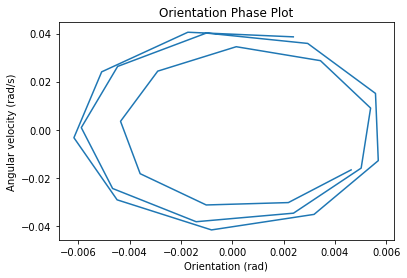

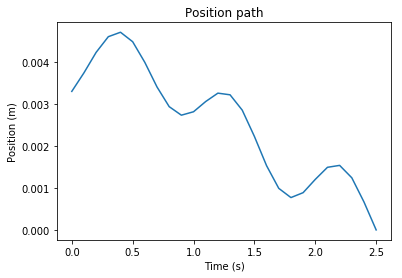

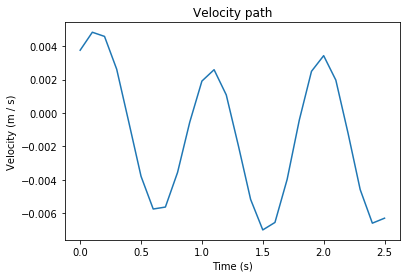

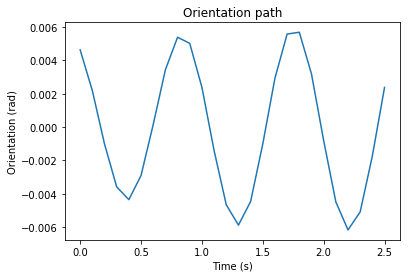

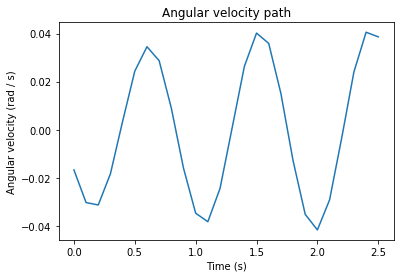

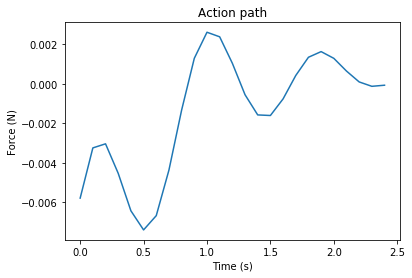

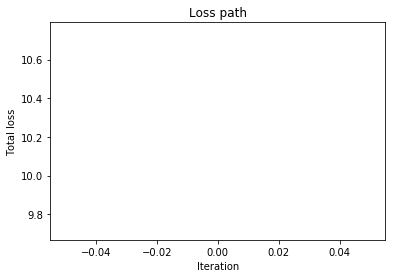

In [20]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


SyntaxError: unexpected EOF while parsing (<string>, line 0)

In [21]:
env.reset()
Z = torch.empty(H + 1, Z.shape[-1])
U = torch.empty(H, model.action_size)
Z[0] = env.get_state().encode(ENCODING)
for i in range(H):
    U[i] = controller(Z[i], i, ENCODING, mpc=True, u_min=U_MIN, u_max=U_MAX, on_iteration=on_iteration)
    env.apply(U[i])
    Z[i + 1] = env.get_state().encode(ENCODING)

iteration 1 iLQRState.ACCEPTED 10.231329 [ 0.00160238  0.01481884  0.00022607 -0.06156415]
iteration 2 iLQRState.CONVERGED 10.231123 [ 0.00302921  0.01302064 -0.0057789  -0.04809571]
iteration 3 iLQRState.CONVERGED 10.230959 [ 0.00435733  0.00850032 -0.01007698 -0.01069862]
iteration 4 iLQRState.CONVERGED 10.230832 [ 0.00499712  0.00279703 -0.00978454  0.03535188]
iteration 5 iLQRState.REJECTED 10.230741 [ 0.00503649 -0.00146732 -0.00431727  0.06970719]
iteration 5 iLQRState.REJECTED 10.230741 [ 0.00503649 -0.00146732 -0.00431727  0.06970719]
iteration 5 iLQRState.REJECTED 10.230741 [ 0.00503649 -0.00146732 -0.00431727  0.06970719]
iteration 5 iLQRState.REJECTED 10.230741 [ 0.00503649 -0.00146732 -0.00431727  0.06970719]
iteration 5 iLQRState.REJECTED 10.230741 [ 0.00503649 -0.00146732 -0.00431727  0.06970719]
iteration 5 iLQRState.CONVERGED 10.23074 [ 0.00474115 -0.00166648 -0.0045744   0.06942304]
iteration 6 iLQRState.CONVERGED 10.230664 [ 0.00400103 -0.00264172  0.00263333  0.07369

/home/juancamilog/workspace/pddp/pddp/controllers/ilqr.py:388: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


iteration 12 iLQRState.CONVERGED 10.230175 [ 0.00404246  0.00597472 -0.0130575  -0.02733586]
iteration 13 iLQRState.CONVERGED 10.230104 [ 0.00480801 -0.00136981 -0.0138729   0.03560295]
iteration 14 iLQRState.REJECTED 10.230075 [ 0.00432008 -0.00774604 -0.00747112  0.08736925]
iteration 14 iLQRState.REJECTED 10.230075 [ 0.00432008 -0.00774604 -0.00747112  0.08736925]
iteration 14 iLQRState.REJECTED 10.230075 [ 0.00432008 -0.00774604 -0.00747112  0.08736925]
iteration 14 iLQRState.REJECTED 10.230075 [ 0.00432008 -0.00774604 -0.00747112  0.08736925]
iteration 14 iLQRState.REJECTED 10.230075 [ 0.00432008 -0.00774604 -0.00747112  0.08736925]
iteration 14 iLQRState.CONVERGED 10.230074 [ 0.0043125  -0.00774216 -0.00763328  0.08728588]
iteration 15 iLQRState.REJECTED 10.230087 [ 0.00341813 -0.00921234  0.0021081   0.10009571]
iteration 15 iLQRState.REJECTED 10.230087 [ 0.00341813 -0.00921234  0.0021081   0.10009571]
iteration 15 iLQRState.REJECTED 10.230087 [ 0.00341813 -0.00921234  0.0021081

iteration 74 iLQRState.CONVERGED 10.217431 [-0.01852443  0.08004679  0.05428423 -0.7409068 ]
iteration 75 iLQRState.CONVERGED 10.218162 [-0.00570922  0.09049736 -0.02735921 -0.8013444 ]
iteration 76 iLQRState.ACCEPTED 10.217499 [ 0.01053182  0.05904974 -0.10152626 -0.49268967]
iteration 77 iLQRState.ACCEPTED 10.2147875 [ 0.02302797 -0.0002115  -0.13432184  0.05587202]
iteration 78 iLQRState.ACCEPTED 10.212629 [ 0.0260421  -0.06393712 -0.10850115  0.6211327 ]
iteration 79 iLQRState.CONVERGED 10.212971 [ 0.0171793  -0.1043727  -0.03010631  0.94859725]
iteration 80 iLQRState.ACCEPTED 10.2136545 [-3.3120532e-04 -9.7730182e-02  6.7852020e-02  8.5224324e-01]
iteration 81 iLQRState.ACCEPTED 10.211484 [-0.01864728 -0.04598065  0.14046273  0.36110294]
iteration 82 iLQRState.ACCEPTED 10.207504 [-0.02986235  0.02807009  0.15494484 -0.31834674]
iteration 83 iLQRState.ACCEPTED 10.205795 [-0.02846063  0.09685984  0.10010341 -0.91436964]
iteration 84 iLQRState.CONVERGED 10.207071 [-0.01358454  0.1268

In [ ]:
plot(Z, U)

In [ ]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

In [ ]:
for i in range(10):
    env.apply(torch.zeros(model.action_size))

In [19]:
env.close()